<a href="https://colab.research.google.com/github/sokanaid/CourseProject2022BiologicalMath/blob/main/data_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Импорт бибилиотек, подключение к диску

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np   

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/simulations

Mounted at /content/drive/
/content/drive/MyDrive/simulations


# Сглаживание результатов симуляций

## Чтение данных

In [3]:
def read_csv_file(directory_path, name):
  file_path = os.path.join(directory_path, name + ".csv")
  print("read file ", file_path)
  return pd.read_csv(file_path)

In [4]:
def read_file(directory_path):
  data = {}
  data["population"] = read_csv_file(directory_path, "population")
  data["population"].drop(data["population"].tail(1).index, inplace=True)
  data["population"].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  return data

## Построение графиков

In [40]:
def print_smoothing_in_one_window(print_data1, print_data2, x, x_name="epochs", start_end = None, title = None, legend1 = "population", legend2 = "smoothing"):
  fig = plt.figure(figsize=(10, 10), dpi=80)
  plt.axis('off')
  plt.title(title or "Smoothing")
  fig.tight_layout(pad=6.0,  h_pad=3, w_pad=3)
  fig.patch.set_visible(False)
  columns_count = 2
  axes = fig.subplots(1)

  axes.plot(x, print_data1, "b", label=legend1)
  axes.plot(x, print_data2, "r", label=legend2)
  axes.legend(loc="lower right")
  axes.set_xlabel(x_name)
  axes.set_ylabel('pop')


In [39]:
def plot_multiple_series(series_list, population, rows):
    num_plots = len(series_list)
    len_x = len(series_list) // 2

    
    fig, axs = plt.subplots(rows, 2, figsize=(20, 5*rows))

    j= 0
    for i in range(len(series_list)):
        axs[i // 2][j].plot(population, "b")
        axs[i // 2][j].plot(series_list[i], "r")
        axs[i // 2][j].set_ylabel(f"Series {i+1}")
        j = (j + 1) % 2
    plt.xlabel("Time")
    plt.show()

In [44]:
def plot_two_series(series_list, population):    
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(population, "b")
    axs[0].plot(series_list[0], "r")
    axs[1].plot(population, "b")
    axs[1].plot(series_list[1], "r")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.show()

## Применение скользящего среднего

In [5]:
def moving_average(series, k):
  print("return",np.average(series[-k:]) )
  return np.average(series[-k:])

In [7]:
data = read_file("/content/drive/MyDrive/simulations/smoothing/")

read file  /content/drive/MyDrive/simulations/smoothing/population.csv


In [8]:
time = data["population"]["time"]
population = data["population"]["pop"]

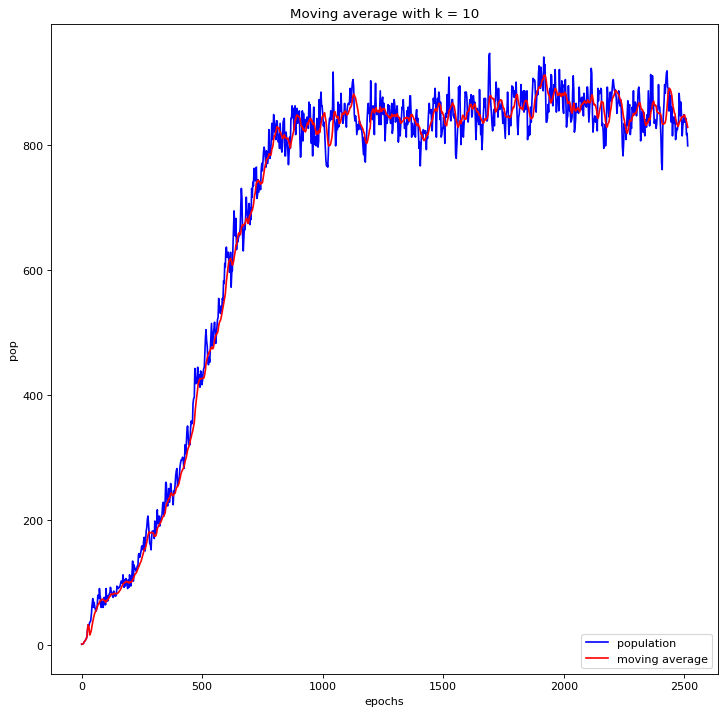

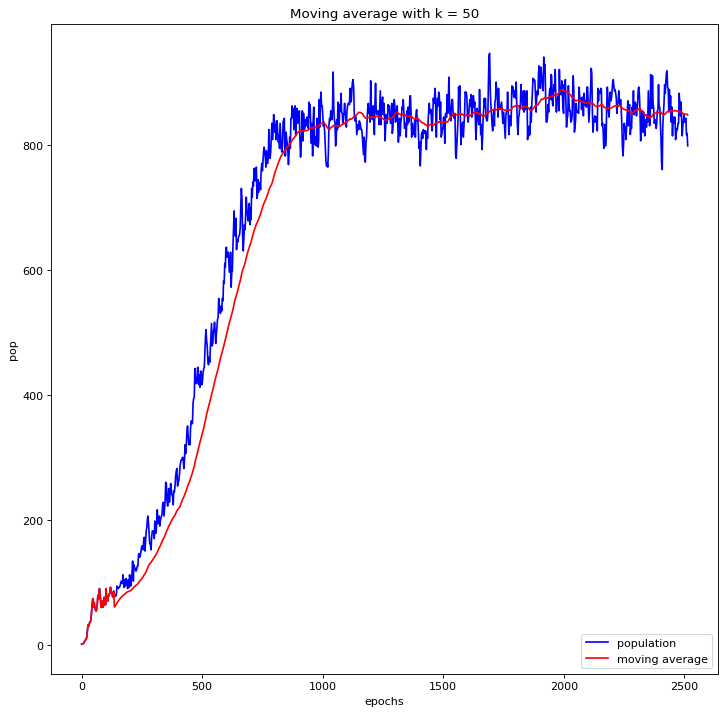

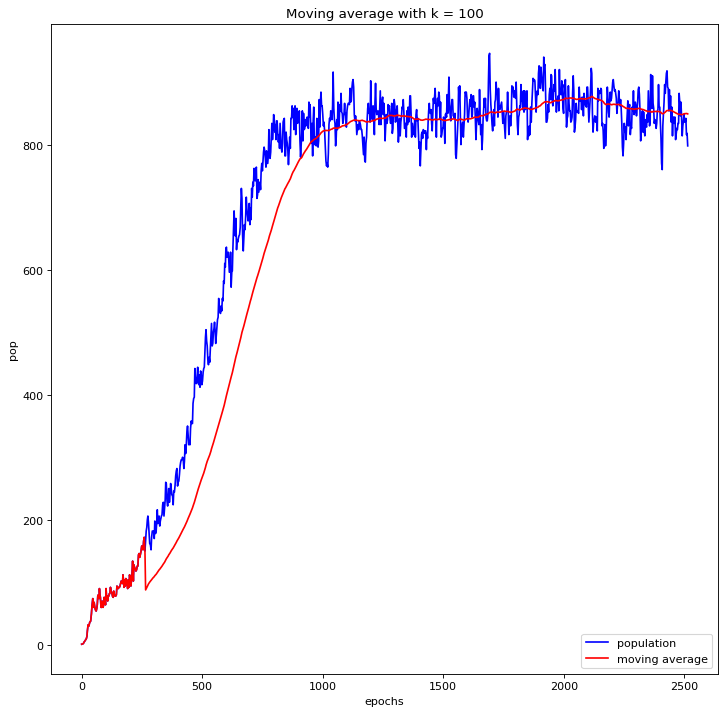

In [12]:
# применение скользящего среднего для разных значений окон - 10, 50, 100
for k in [10, 50, 100]:
  smoothing_data = population[:k - 1 ]
  for i in range(k - 1 , len(population)):
    y_i =  np.average(population[i-(k-1): i+1])
    smoothing_data = pd.concat([smoothing_data, pd.Series(y_i)], ignore_index=True)
  print_smoothing_in_one_window(print_data1=population, print_data2=smoothing_data, x=time, legend2 = "moving average", title="Moving average with k = {}".format(k))
  

## Простое экспонециальное сглаживание с помощью stats models

In [17]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [18]:
fit3 = SimpleExpSmoothing(population).fit()

In [19]:
fit3.params

{'smoothing_level': 0.7268790948444178,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1.4962545021169815,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Подбор оптимального параметра для экспоненциального сглаживания




In [27]:
import numpy as np
from scipy.optimize import minimize

def exponential_smoothing_mae(alpha, series):
    n = len(series)
    y_pred = np.zeros(n)
    y_pred[0] = series[0]
    for i in range(1, n):
        y_pred[i] = alpha * series[i-1] + (1-alpha) * y_pred[i-1]
    mae = np.mean(np.abs(series - y_pred))
    return mae

def find_optimal_params(series):
    alpha0 = 0.1
    alpha_bounds = [(0.001, 1)]

    res = minimize(exponential_smoothing_mae, alpha0, args=(series), bounds=alpha_bounds)
    optimal_params = res.x

    return optimal_params

In [30]:
a = find_optimal_params(population)[0]
print(a)

0.6834870265533882


In [14]:
def simple_exponential_smoothing(series, alpha):
  smoothing_data = series[:1]
  for i in range(1 , len(series)):
    y_i =  alpha*series[i] + smoothing_data[i-1]*(1-alpha)
    smoothing_data = pd.concat([smoothing_data, pd.Series(y_i)], ignore_index=True)
  return smoothing_data

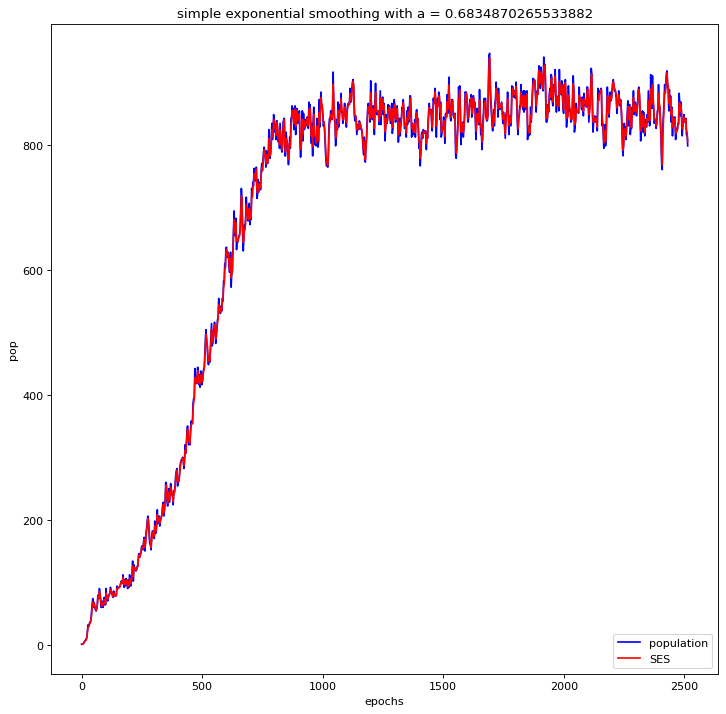

In [32]:
print_smoothing_in_one_window(print_data1=population, print_data2=simple_exponential_smoothing(population, a), x=time, legend2 = "SES", title="simple exponential smoothing with a = {}".format(a))

## Применение простого экспоненциального сглаживания

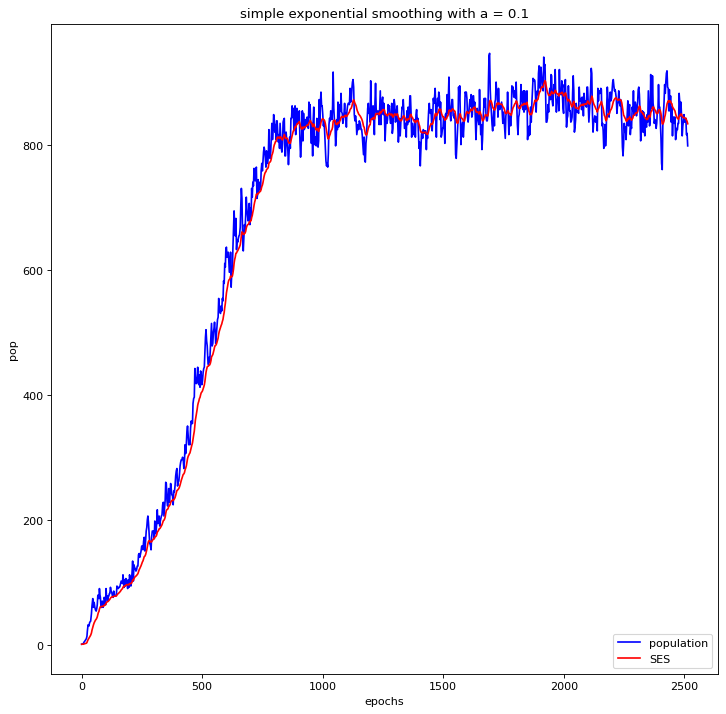

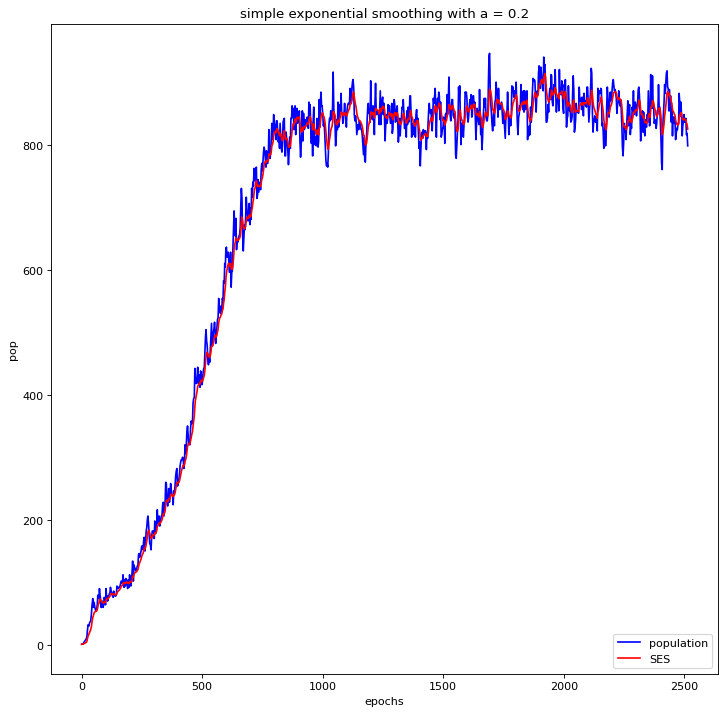

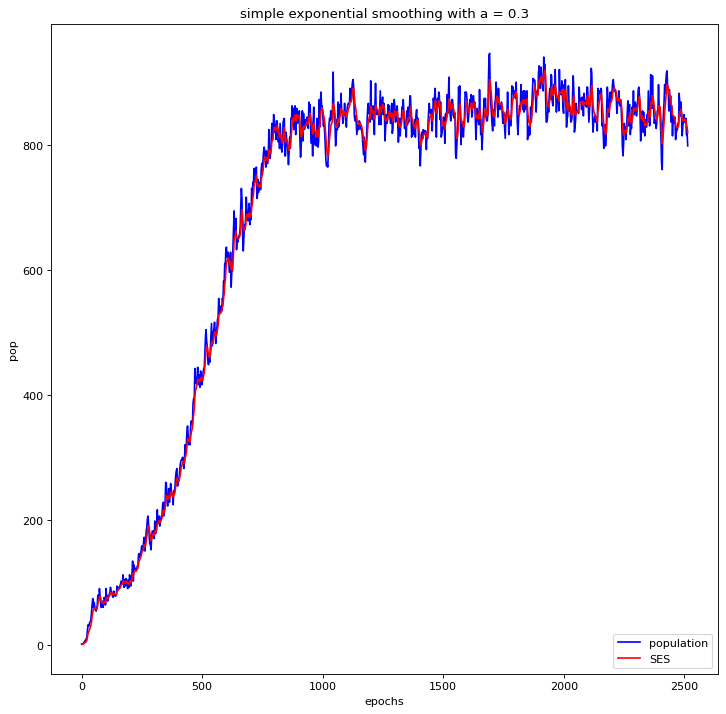

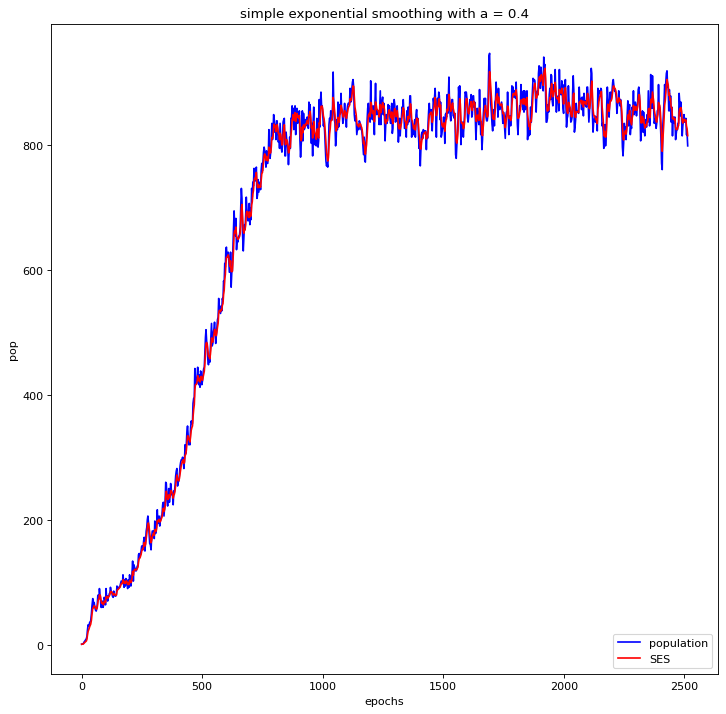

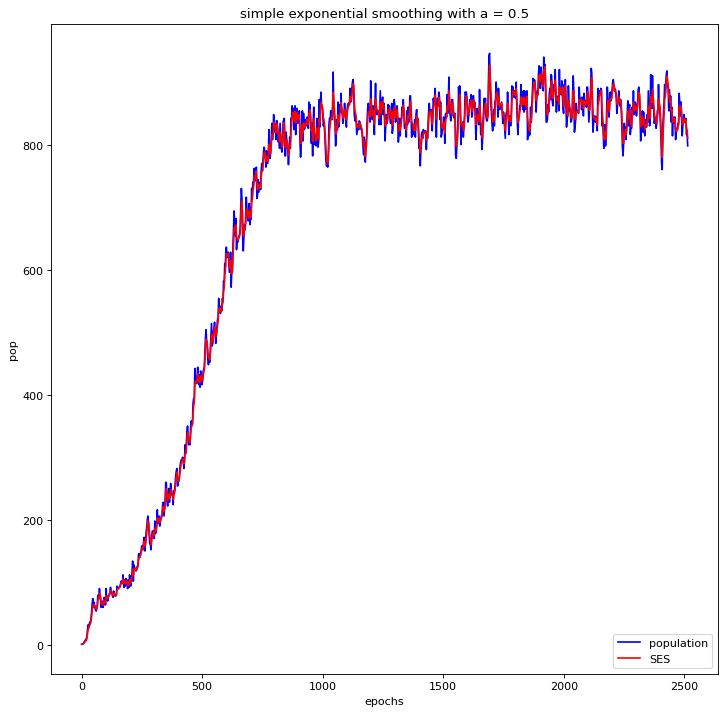

In [33]:
for a in [0.1, 0.2, 0.3, 0.4, 0.5]:
  smoothing_data = simple_exponential_smoothing(population, a)
  print_smoothing_in_one_window(print_data1=population, print_data2=smoothing_data, x=time, legend2 = "SES", title="simple exponential smoothing with a = {}".format(a))

## Последовательное экспоненциальное сглаживание с alpha = 0.3, 6 итерация

In [45]:
def multiple_exponential_smoothing(series, alphas):
    smoothed_series = []
    current_series = series.copy()
    
    for alpha in alphas:
        current_series = simple_exponential_smoothing(current_series, alpha)
        smoothed_series.append(current_series)
    
    return smoothed_series

In [48]:
smoothed = multiple_exponential_smoothing(population, [0.3]*10)

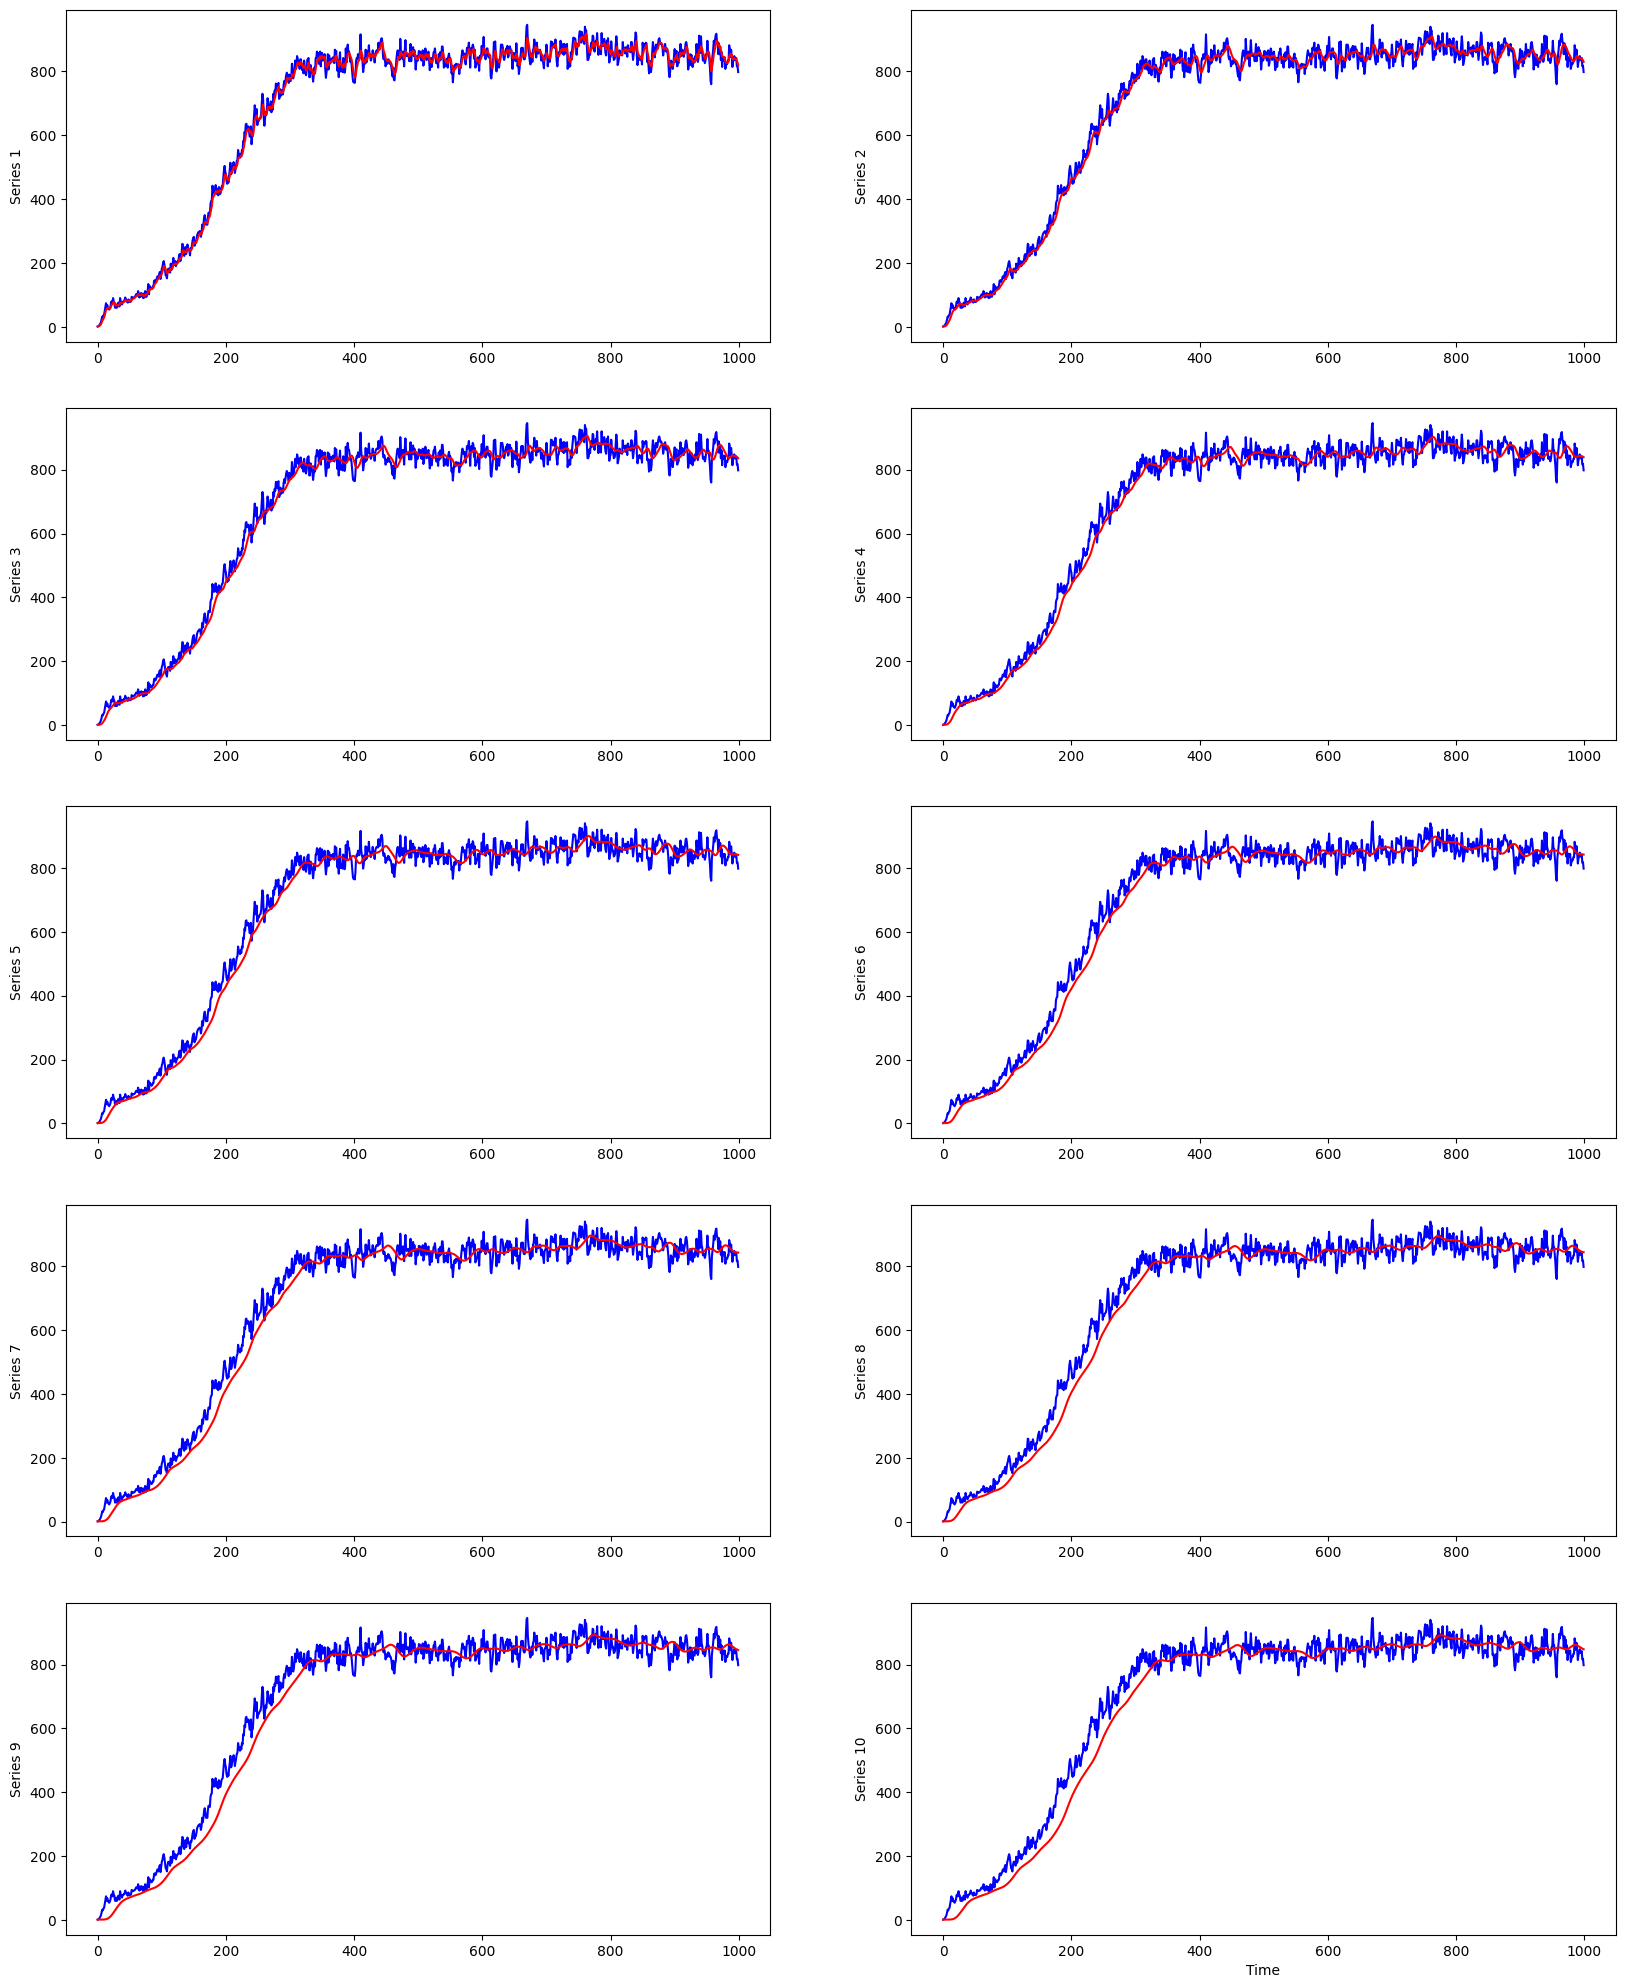

In [49]:
plot_multiple_series(smoothed, population, 5)

## Пример симуляции 2

In [53]:
sim2= read_file("/content/drive/MyDrive/simulations/smoothing/smoothing_2")

read file  /content/drive/MyDrive/simulations/smoothing/smoothing_2/population.csv


In [54]:
time2 = sim2["population"]["time"]
population2 = sim2["population"]["pop"]

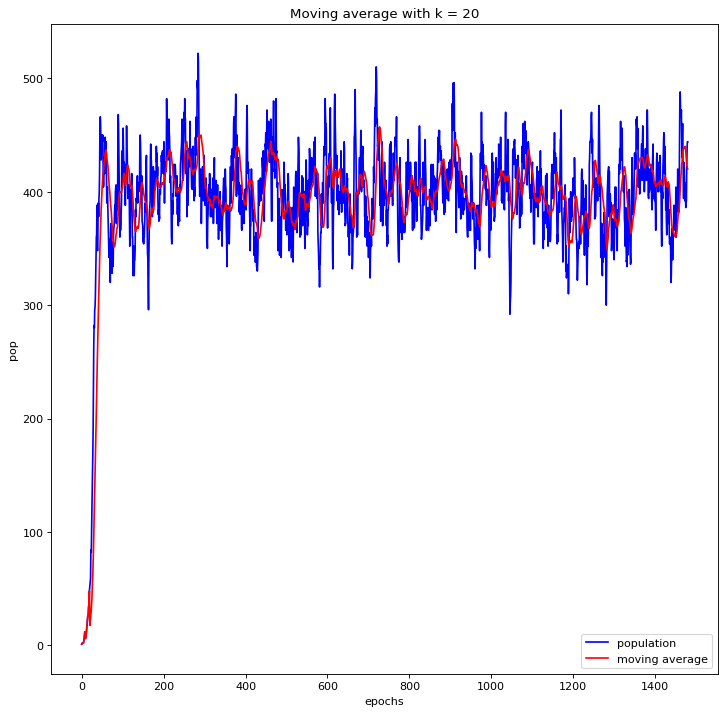

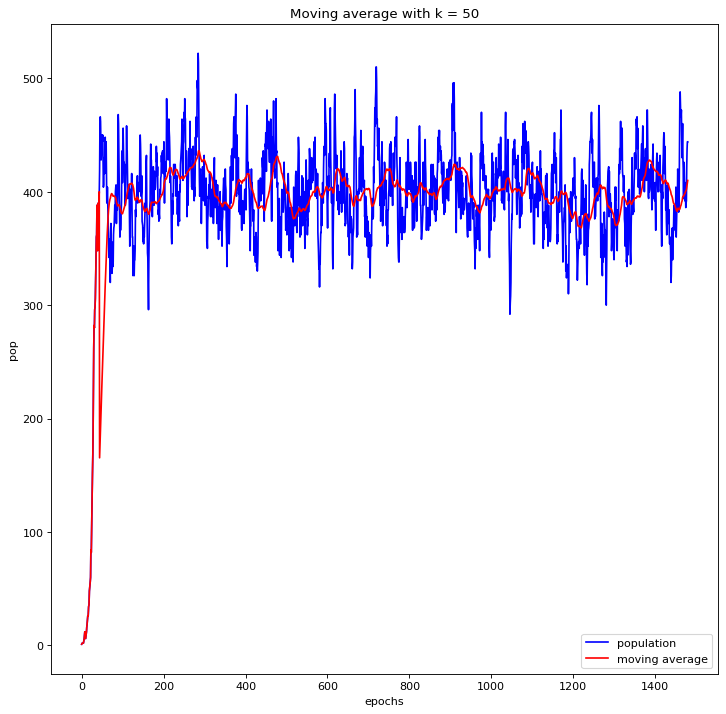

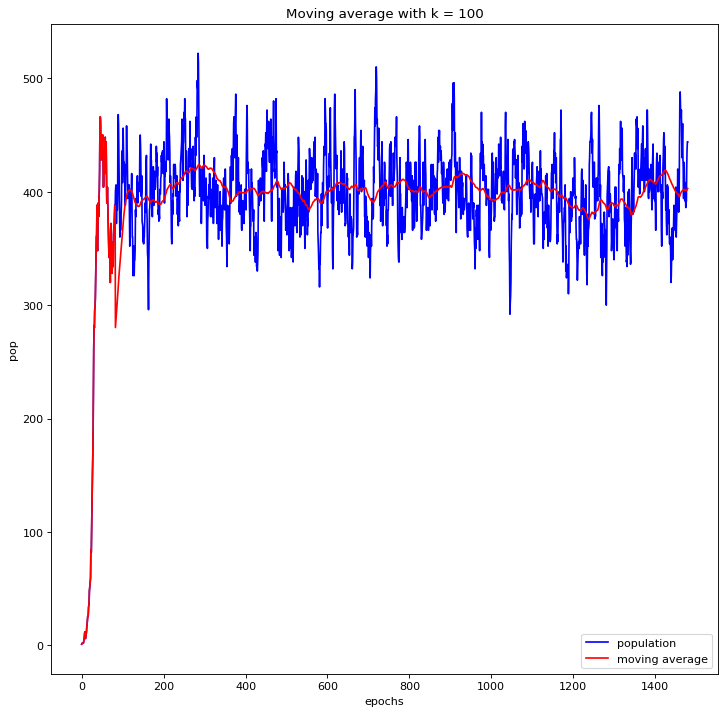

In [56]:
for k in [20, 50, 100]:
  smoothing_data_2 = population2[:k - 1 ]
  for i in range(k - 1 , len(population2)):
    y_i =  np.average(population2[i-(k-1): i+1])
    smoothing_data_2 = pd.concat([smoothing_data_2, pd.Series(y_i)], ignore_index=True)
  print_smoothing_in_one_window(print_data1=population2, print_data2=smoothing_data_2, x=time2, legend2 = "moving average", title="Moving average with k = {}".format(k))
  

In [57]:
smoothed2 = multiple_exponential_smoothing(population2, [0.3]*10)

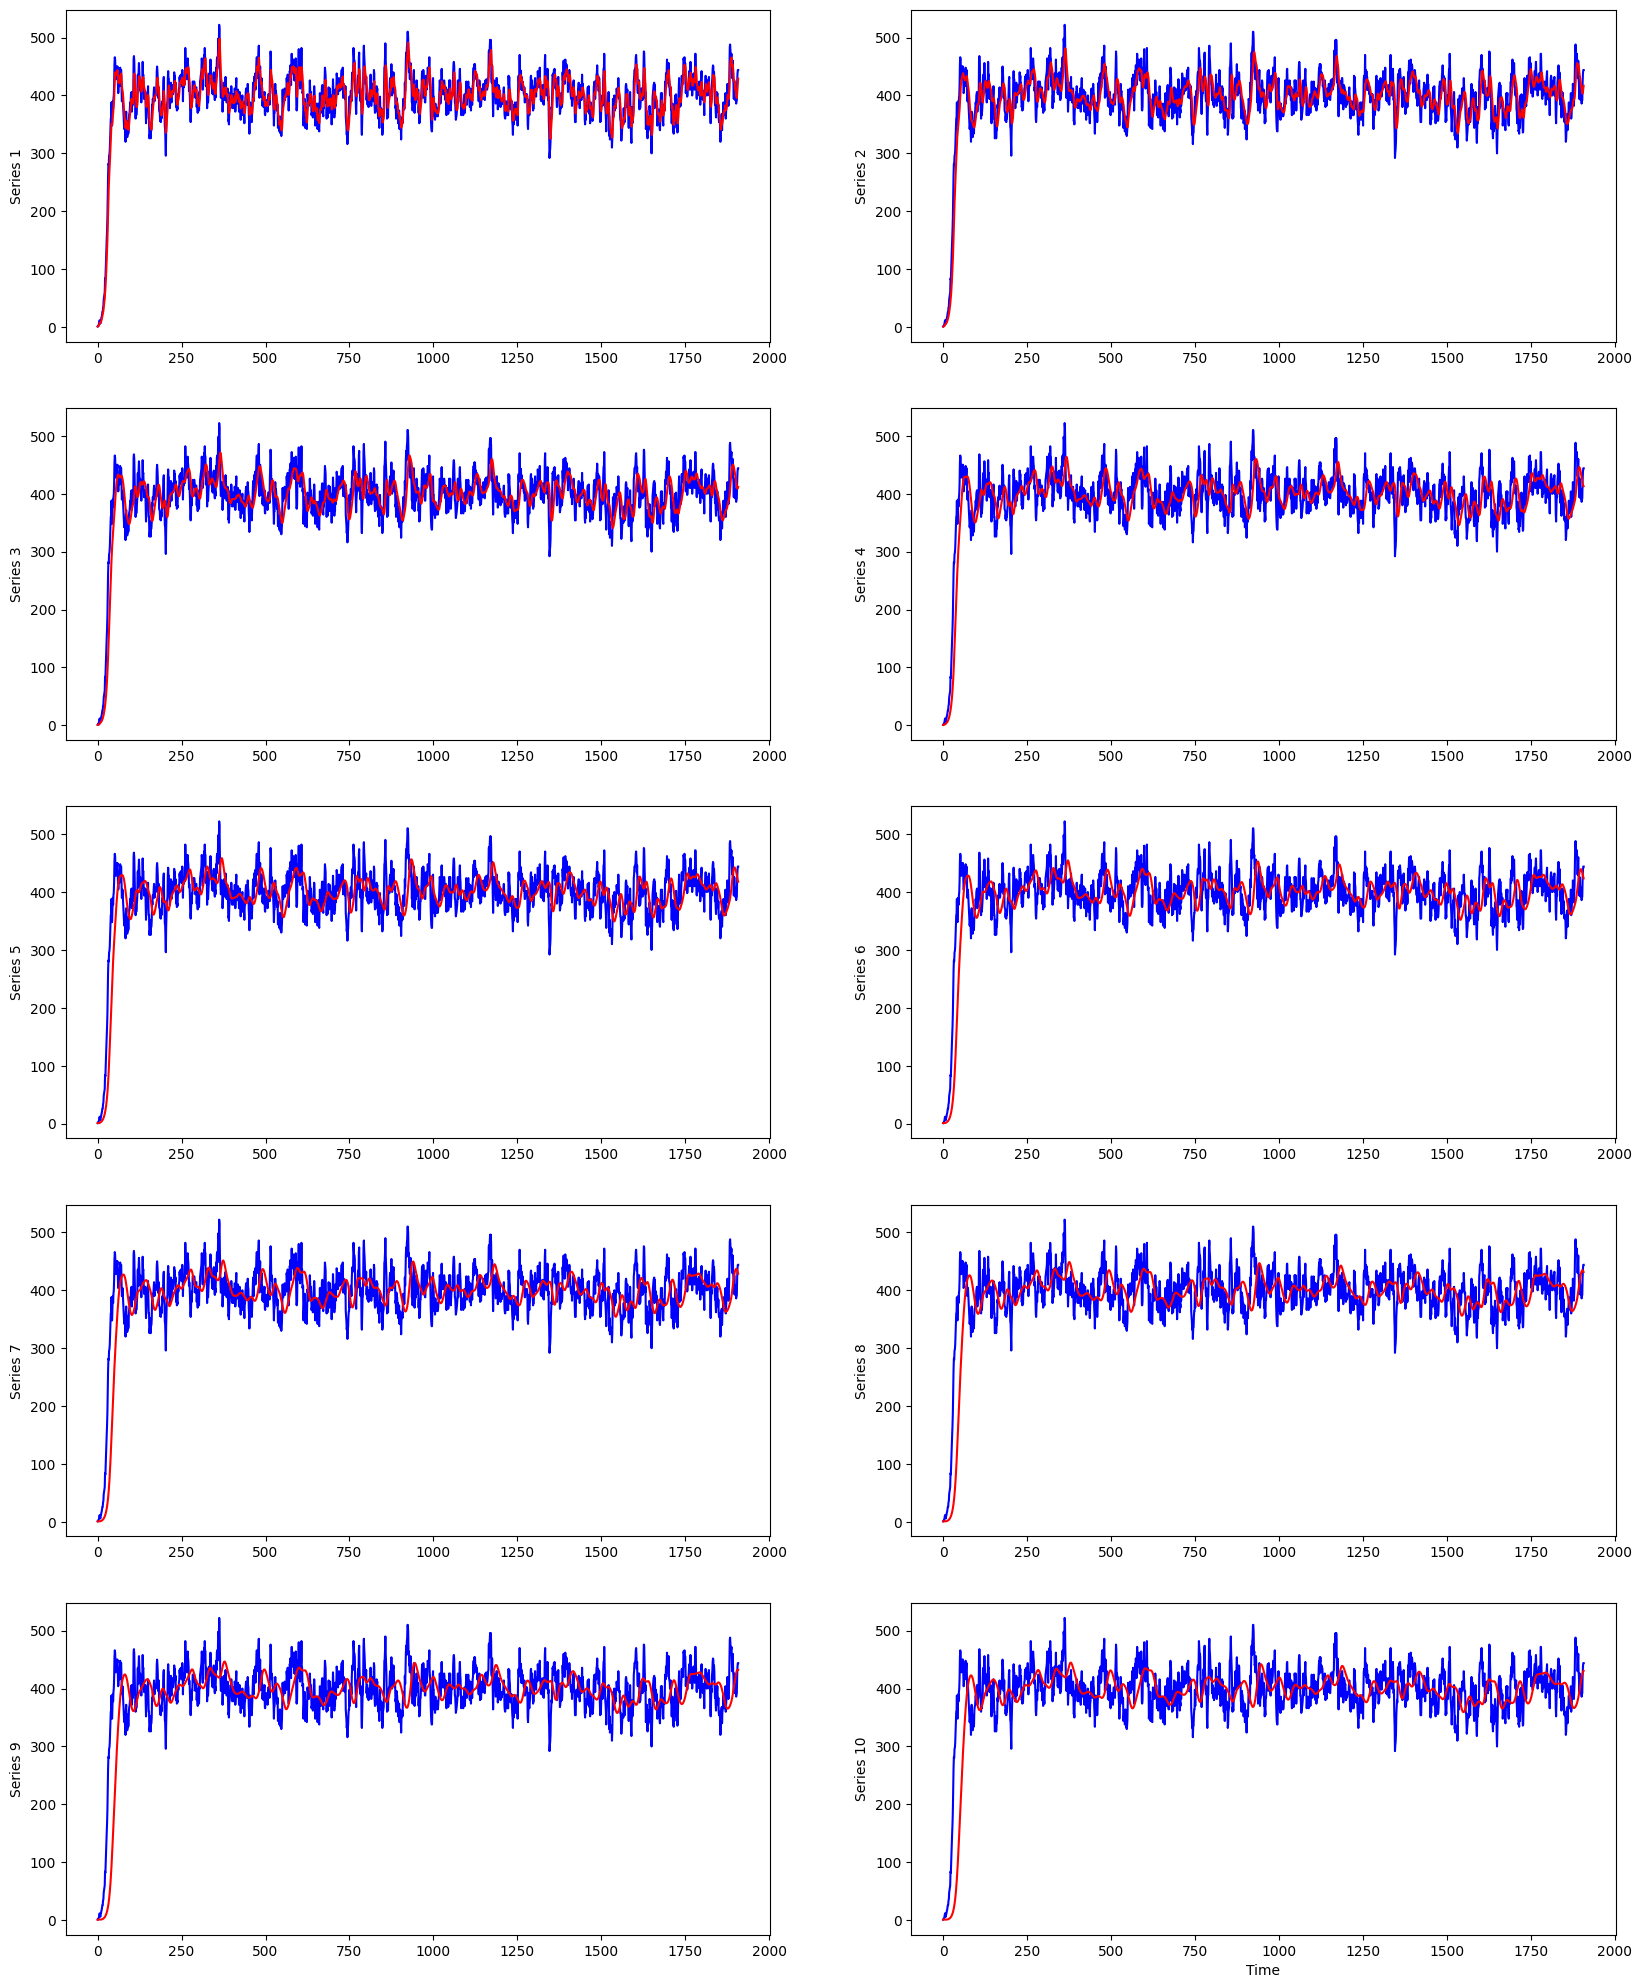

In [60]:
plot_multiple_series(smoothed2, population2, 5)

## Пример симуляции 3

In [61]:
sim3= read_file("/content/drive/MyDrive/simulations/smoothing/smoothing_3")

read file  /content/drive/MyDrive/simulations/smoothing/smoothing_3/population.csv


In [62]:
time3 = sim3["population"]["time"]
population3 = sim3["population"]["pop"]

In [63]:
smoothed3 = multiple_exponential_smoothing(population3, [0.3]*10)

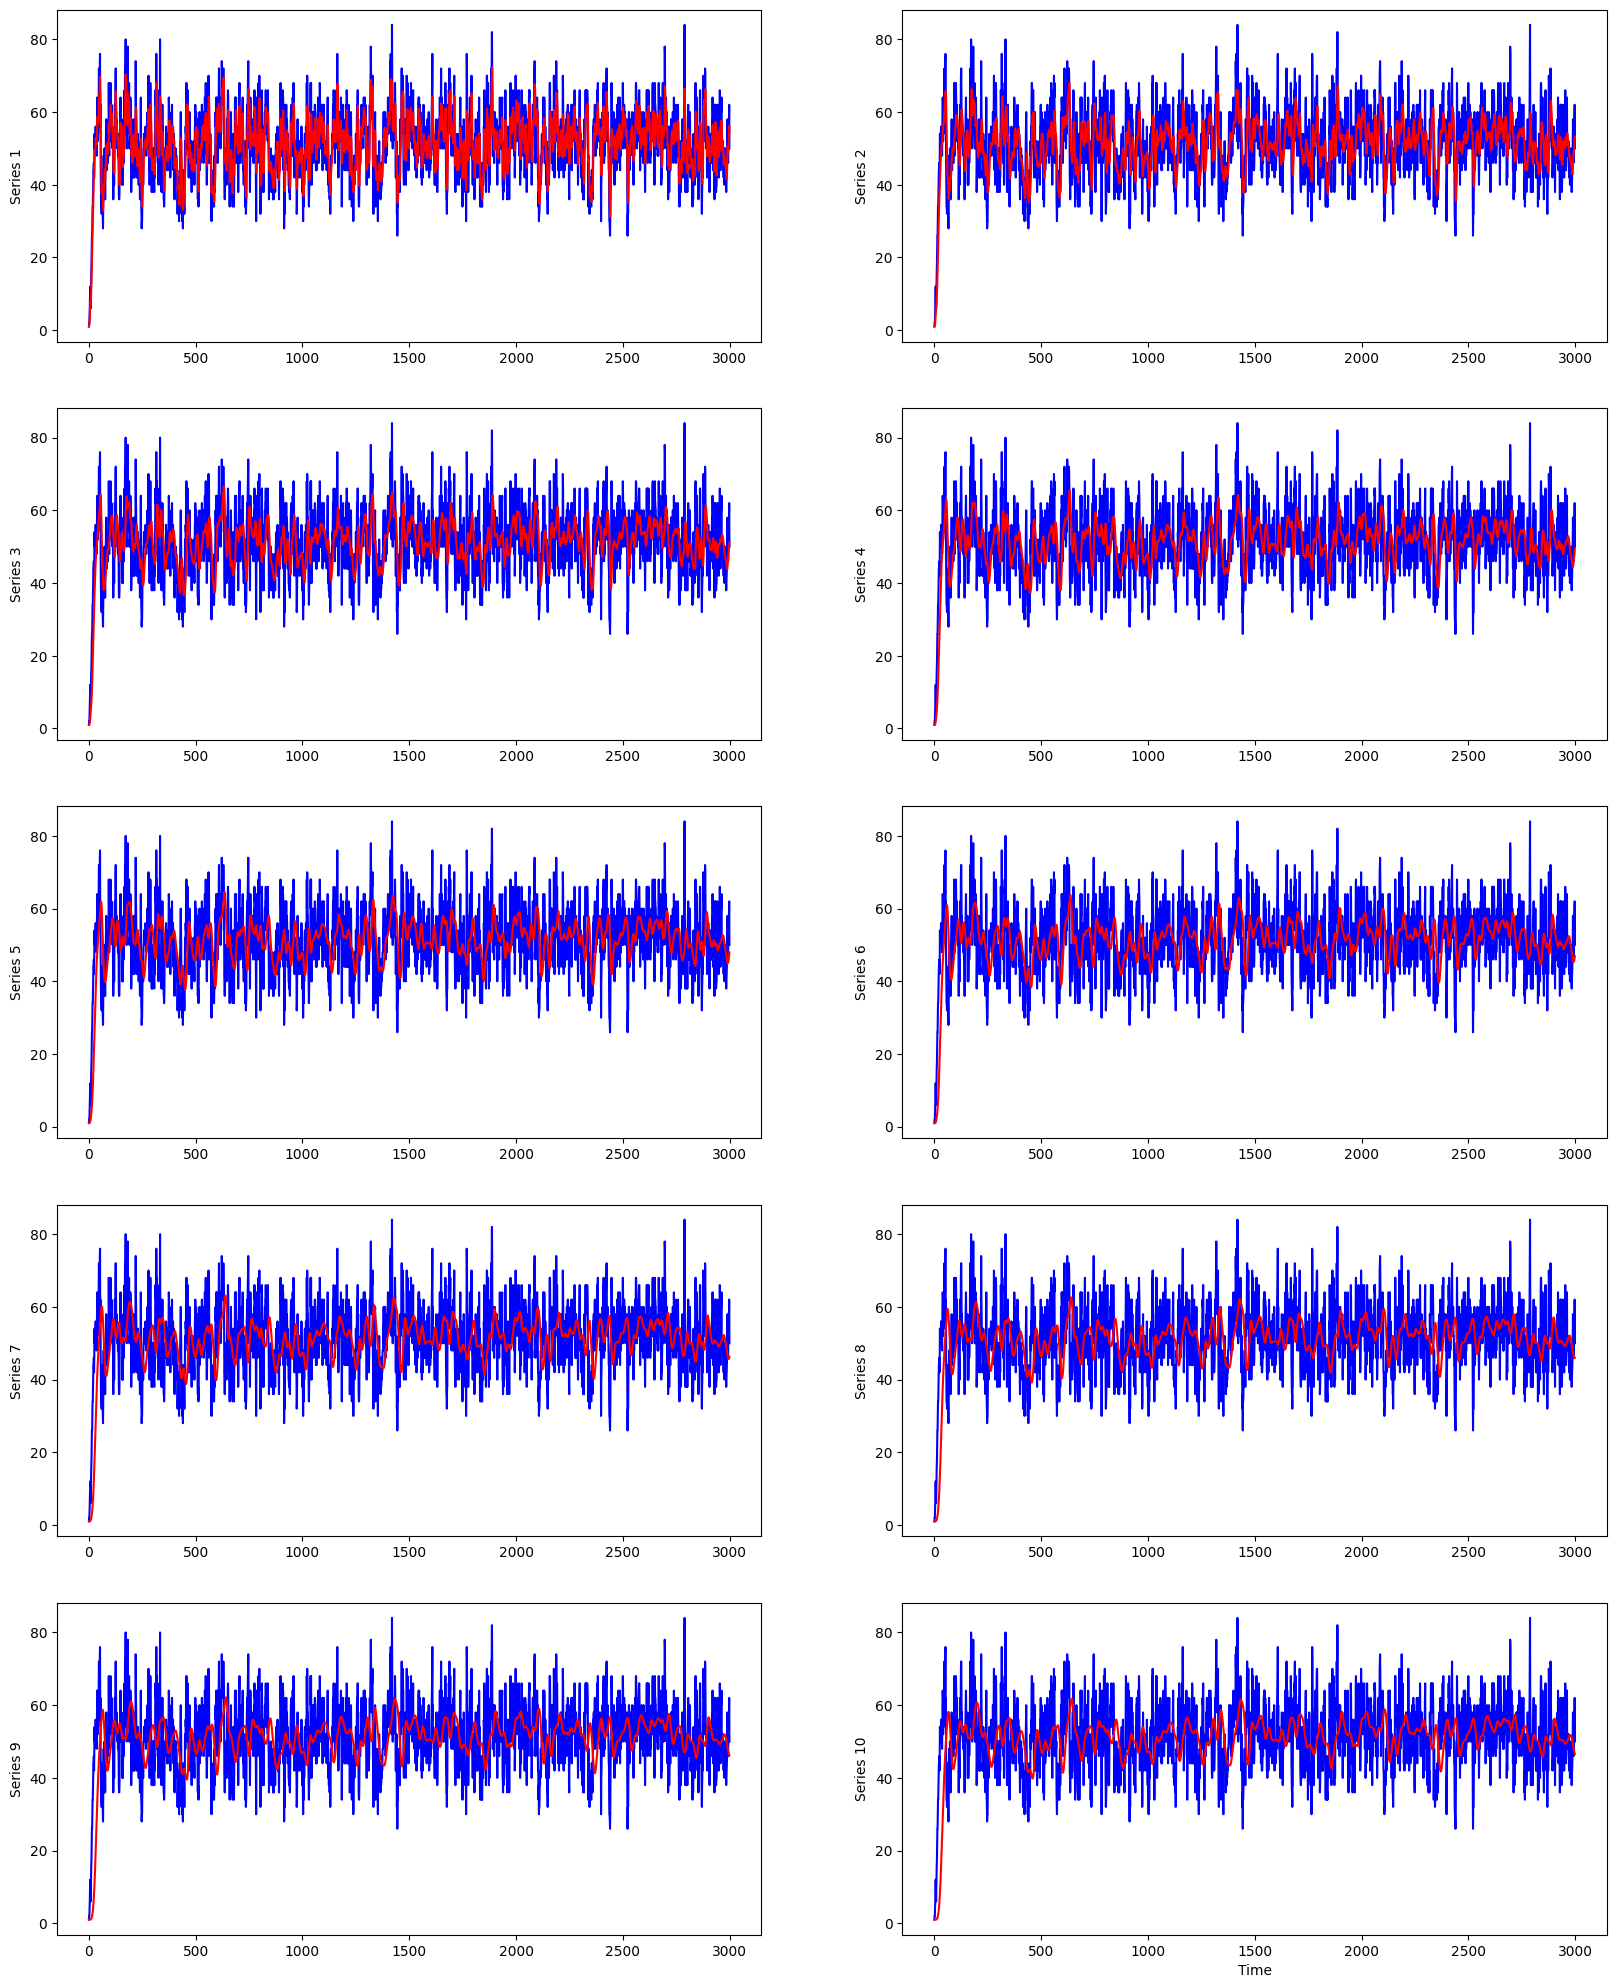

In [65]:
plot_multiple_series(smoothed3, population3, 5)

## Двойное экспоненциальное сглаживание

In [68]:
def double_exponential_smoothing(params, series):
    alpha, beta = params
    level = series[0]
    trend = series[1] - series[0]
    smoothed = np.zeros(len(series))
    smoothed[0] = series[0]
    smoothed[1] = series[1]

    for i in range(2, len(series)):
        prev_level, level = level, alpha * series[i] + (1 - alpha) * (level + trend)
        trend = beta * (level - prev_level) + (1 - beta) * trend
        smoothed[i] = level + trend
    return smoothed


In [69]:
smoothed = []
smoothed.append(double_exponential_smoothing([0.4, 0.3], population))
smoothed.append(double_exponential_smoothing([0.4, 0.0], population))

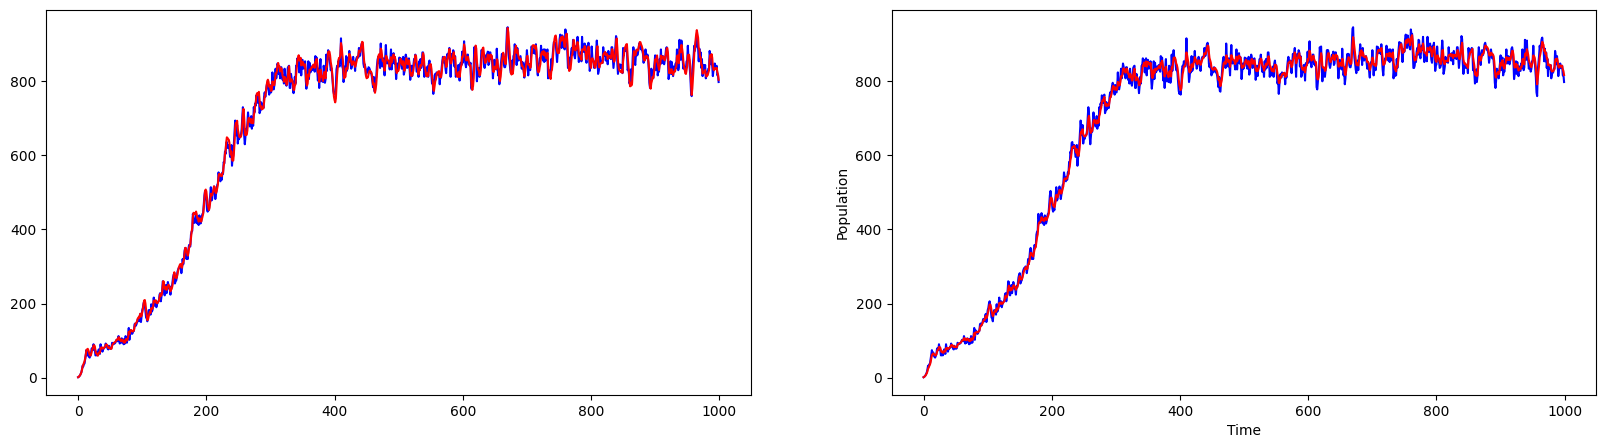

In [70]:
plot_two_series(smoothed, population)